In [64]:
import csv
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import scipy
import tensorflow as tf
import time
import uproot
import zfit

In [65]:
def partition_helper(slice_entries, file_entries, file_curr, entry_curr):
    if slice_entries <= file_entries[file_curr] - entry_curr:
        return [file_curr, slice_entries + entry_curr]
    elif file_curr == len(file_entries) - 1:
        return [file_curr, file_entries[-1]]
    else:
        return partition_helper(slice_entries - file_entries[file_curr] + entry_curr, file_entries, file_curr + 1, 0)

def partition(files, n_processes):
    file_entries = [file.num_entries for file in files]
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    for i in range(n_processes):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

def read_slice(files, slices, index, expressions, cut, data):
    data_slice = []
    for i in range(slices[index][0], slices[index][2] + 1):
        data_slice.append(files[i].arrays(expressions=expressions, 
                              cut=cut,
                              entry_start=slices[index][1] if i == slices[index][0] else None,
                              entry_stop=slices[index][3] if i == slices[index][2] else None,
                              library="pd"))
    data.append(pd.concat(data_slice))

def to_pandas(path, tree, n_files, n_processes, expressions, cut=None):
    files = [uproot.open(path=path + filename + ":" + tree) for filename in sorted(os.listdir(path))[:n_files]]
    slices = partition(files, n_processes)
    data = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=read_slice, args=[files, slices, i, expressions, cut, data])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    
    return pd.concat(data)

In [66]:
path = "../data/128_files/"

In [85]:
start = time.time()
data = to_pandas(path, "rootuple/CandidateTree", 128, 64, 
                "candidate_vMass",
                "(candidate_charge == 0)\
                & (candidate_cosAlpha > 0.99)\
                & (candidate_lxy / candidate_lxyErr > 3.0)\
                & (candidate_vProb > 0.05)\
                & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)")
time.time() - start

21.147677183151245

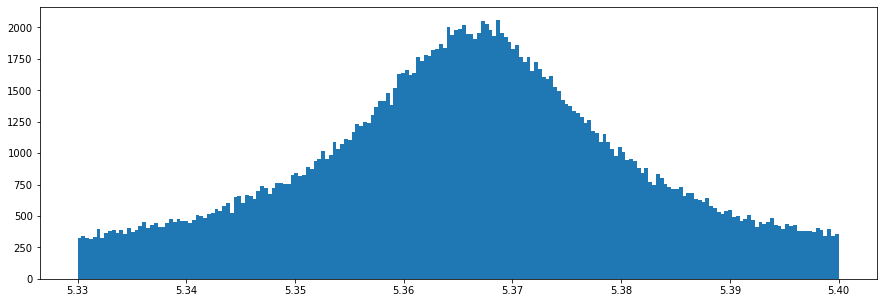

In [5]:
plt.figure(figsize=(15, 5))
plt.hist(data["candidate_vMass"], bins=200)
plt.show()

In [69]:
def parameter(name, value, lower=None, upper=None):
    try:
        return zfit.Parameter(name, value, lower, upper)
    except zfit.exception.NameAlreadyTakenError:
        del zfit.Parameter._existing_params[name]
        return zfit.Parameter(name, value, lower, upper)

In [81]:
mass = zfit.Space('candidate_vMass', limits=(5.33, 5.4))

mu = parameter("mu", 5.37, 5.33, 5.4)
sigma = parameter("sigma", 0.01, 0.001, 0.2)
signal = zfit.pdf.Gauss(obs=mass, mu=mu, sigma=sigma)

a0 = parameter("a0", 0.5, 0.0, 1.0)
a1 = parameter("a1", -0.3, -0.5, 1.0)
bkg = zfit.pdf.Chebyshev(obs=mass, coeffs=[a0, a1])

fraction = parameter("fraction", 0.5, 0, 1)

model = zfit.pdf.SumPDF([signal, bkg], fraction)

In [82]:
nll = zfit.loss.UnbinnedNLL(model=model, data=zfit.Data.from_pandas(data))  # loss

minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)

print(minimum)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_13, fraction]] data=[<zfit.core.data.Data object at 0x7efb3ef3b940>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.3e-06 │ -7740       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value    at limit
--------  --------  ----------
fraction    0.4156       False
mu           5.367       False
sigma     0.008588       False
a0         0.02811       False
a1         -0.3602       False


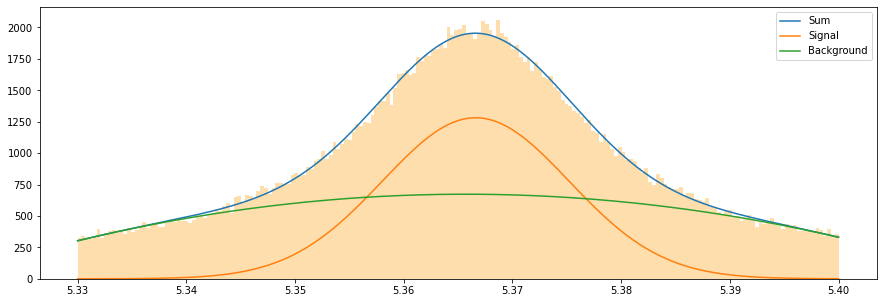

In [84]:
mass_range = (5.33, 5.4)
n_bins = 200

plt.figure(figsize=(15, 5))
plt.hist(data["candidate_vMass"], bins=n_bins, color="navajowhite")

mass = np.linspace(*mass_range, num=1000)

pdf = zfit.run(model.pdf(mass))
gauss = (signal.pdf(mass) * fraction).numpy()
chebyshev = (bkg.pdf(mass) * (1 - fraction)).numpy()

scale = len(data["candidate_vMass"]) / n_bins * (mass_range[1] - mass_range[0])

plt.plot(mass, pdf * scale, label="Sum")
plt.plot(mass, gauss * scale, label="Signal")
plt.plot(mass, chebyshev * scale, label="Background")
plt.legend()